In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
latent_dimension = 100
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 200

#Datasets


tensor2image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainset = MNIST(".", transform=tensor2image_transforms, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size)

In [ ]:
class MNISTConditionalGenerator(nn.Module):
    def __init__(self,
                 latent_dimension=100,
                 num_embeddings=10,
                 embedding_dim=16):

        super().__init__()

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        self.generator = nn.Sequential(
            nn.Linear(latent_dimension+embedding_dim, 256),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        batch_size = noise.shape[0]

        #Get Digit Embeddings
        embeddings = self.embeddings(labels)

        #Concat Embeddings onto Noise
        noise = torch.cat([noise, embeddings], dim=-1)

        #Pass Noise+Embeddings into Generator
        generated = self.generator(noise)
        return generated.reshape(batch_size, 1, 28, 28)

class MNISTConditionalDiscriminator(nn.Module):
    def __init__(self,
                 num_embeddings=10,
                 embedding_dim=16):
        super().__init__()

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        self.discriminator = nn.Sequential(
            nn.Linear(784+embedding_dim, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 1),
        )

    def forward(self, x, labels):
        batch_size = x.shape[0]

        # Get Digit Embeddings
        embeddings = self.embeddings(labels)

        # Flatten Images to Vectors
        x = x.reshape(batch_size, -1)

        # Concat Embeddings to Images
        x = torch.cat([x, embeddings], dim=-1)

        return self.discriminator(x)

generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001

# Define Models
generator = MNISTConditionalGenerator().to(device)
discriminator = MNISTConditionalDiscriminator().to(device)

# Define Optimizers
gen_optimizer = optim.Adam(generator.parameters(), generator_learning_rate)
disc_optimizer = optim.Adam(discriminator.parameters(), discriminator_learning_rate)

def train_conditional_gan(generator,
                          discriminator,
                          generator_optimizer,
                          discriminator_optimizer,
                          dataloader,
                          label_smoothing=0.05,
                          epochs=200,
                          device="cpu",
                          plot_generation_freq=50,
                          plot_loss_freq=20,
                          num_classes=10):

    # Define Loss Function (Will do Sigmoid Internally)
    loss_func = nn.BCEWithLogitsLoss()

    gen_losses, disc_losses = [], []

    for epoch in tqdm(range(epochs)):

        generator_epoch_losses = []
        discriminator_epoch_losses = []

        for images, true_digits in dataloader:

            batch_size = images.shape[0]


            images = images.to(device)
            true_digits = true_digits.to(device)

            #noise for Generation ###
            rand_digits = torch.randint(0,num_classes, size=(batch_size,), device=device)
            noise = torch.randn(batch_size, latent_dimension, device=device)

            generated_labels = torch.zeros(batch_size, 1, device=device) + label_smoothing
            true_labels = torch.ones(batch_size, 1, device=device) - label_smoothing


            generated_images = generator(noise, rand_digits).detach()

            # Pass Generated and Real Images into Discriminator
            real_discriminator_pred = discriminator(images, true_digits)
            gen_discriminator_pred = discriminator(generated_images, rand_digits)

            # Compute Discriminator Loss
            real_loss = loss_func(real_discriminator_pred, true_labels)
            fake_loss = loss_func(gen_discriminator_pred, generated_labels)
            discriminator_loss = (real_loss + fake_loss) / 2
            discriminator_epoch_losses.append(discriminator_loss.item())

            # Update Discriminator
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            #Sample noise for Generation
            rand_digits = torch.randint(0,num_classes, size=(batch_size,), device=device)
            noise = torch.randn(batch_size, latent_dimension, device=device)

            # Generate Images
            generated_images = generator(noise, rand_digits)

            # Pass Into Discriminator
            gen_discriminator_pred = discriminator(generated_images, rand_digits)

            # Compute Generator Loss
            generator_loss = loss_func(gen_discriminator_pred, true_labels)
            generator_epoch_losses.append(generator_loss.item())

            #Update the Generator
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()

        generator_epoch_losses = np.mean(generator_epoch_losses)
        discriminator_epoch_losses = np.mean(discriminator_epoch_losses)

        if epoch % plot_loss_freq == 0:
            print(f"Epoch: {epoch}/{epochs} | Generator Loss: {generator_epoch_losses} | Discriminator Loss: {discriminator_epoch_losses}")

        gen_losses.append(generator_epoch_losses)
        disc_losses.append(discriminator_epoch_losses)

        if epoch % plot_generation_freq == 0:
            generator.eval()
            with torch.no_grad():
                digits = torch.arange(num_classes, device=device)
                noise_sample = torch.randn(num_classes, latent_dimension, device=device)
                generated_imgs = generator(noise_sample, digits).to("cpu")

                fig, ax = plt.subplots(1,num_classes, figsize=(15,5))

                for i in range(num_classes):
                    img = (generated_imgs[i].squeeze() + 1)/2
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].set_axis_off()

                plt.show()

            generator.train()

    return generator, discriminator, gen_losses, disc_losses


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0/200 | Generator Loss: 1.6287542076380268 | Discriminator Loss: 0.45768758619645


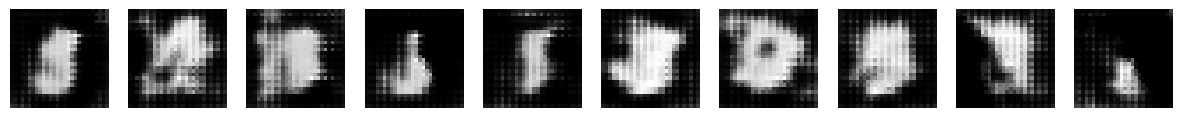

Epoch: 20/200 | Generator Loss: 0.7412424284512046 | Discriminator Loss: 0.6742882718409556


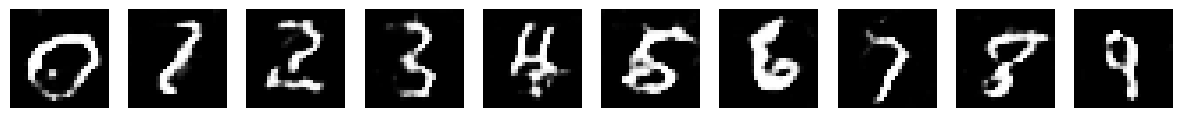

Epoch: 40/200 | Generator Loss: 0.7171598980421705 | Discriminator Loss: 0.6838024886432232


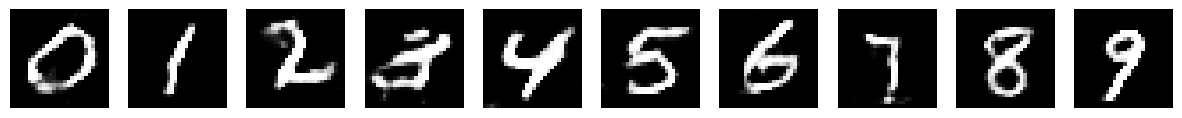

Epoch: 60/200 | Generator Loss: 0.709686761217585 | Discriminator Loss: 0.6868533080320622


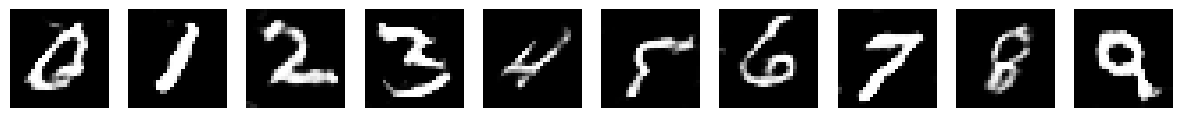

Epoch: 80/200 | Generator Loss: 0.7003523270204377 | Discriminator Loss: 0.6896507132536313


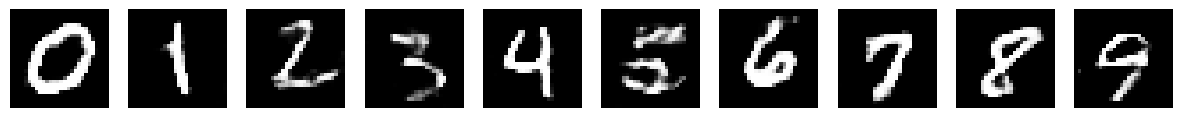

Epoch: 100/200 | Generator Loss: 0.7168722170502392 | Discriminator Loss: 0.6870654274914056


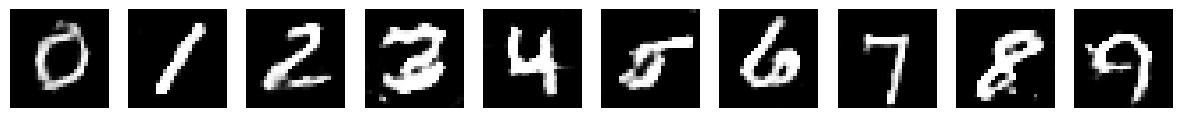

Epoch: 120/200 | Generator Loss: 0.7115093355239835 | Discriminator Loss: 0.6882737289105397


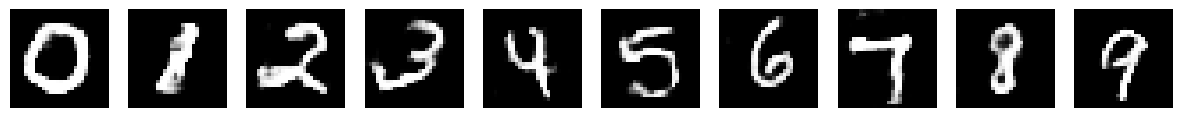

Epoch: 140/200 | Generator Loss: 0.7060326457277798 | Discriminator Loss: 0.6890319532422877


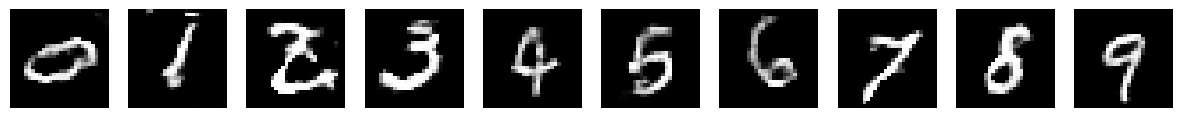

Epoch: 160/200 | Generator Loss: 0.7127039281289969 | Discriminator Loss: 0.689216693200028


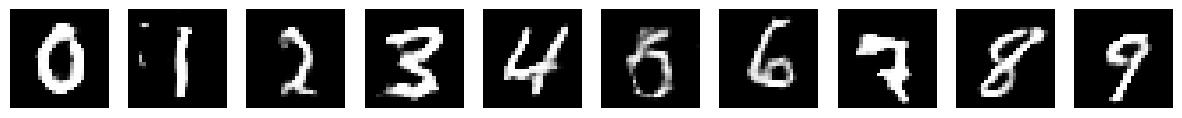

Epoch: 180/200 | Generator Loss: 0.7069291969352185 | Discriminator Loss: 0.6899656488188802


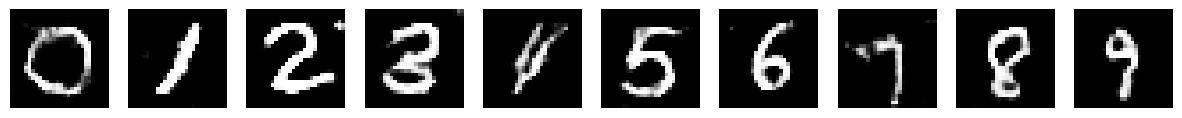

In [ ]:




class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, interpolate=False):
        super().__init__()
        if interpolate:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=3,
                          padding="same")
            )

        else:
            self.upsample = nn.ConvTranspose2d(in_channels,
                                               out_channels,
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1)


    def forward(self, x):
        return self.upsample(x)

class ConvMNISTConditionalGenerator(nn.Module):
    def __init__(self,
                 in_channels=128,
                 start_dim=7,
                 latent_dimension=100,
                 num_embeddings=10,
                 embedding_dim=16,
                 interpolate=False):

        super().__init__()

        self.start_dim = start_dim
        self.in_channels = in_channels

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        self.lin2img = nn.Linear(latent_dimension+embedding_dim, in_channels * start_dim * start_dim)

        self.generator = nn.Sequential(
            UpsampleBlock(in_channels, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,128,kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            UpsampleBlock(128, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,1,kernel_size=3, padding="same"),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        batch_size = noise.shape[0]

        # Get Digit Embeddings
        embeddings = self.embeddings(labels)

        # Concat Embeddings onto Noise
        noise = torch.cat([noise, embeddings], dim=-1)

        # Project Noise to Img Space
        noise = self.lin2img(noise)

        #Reshape Noise to Image Shape
        noise = noise.reshape(batch_size, self.in_channels, self.start_dim, self.start_dim)

        #Pass Noise+Embeddings into Generator
        generated = self.generator(noise)

        return generated.reshape(batch_size, 1, 28, 28)

generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001

# Define Models
generator = ConvMNISTConditionalGenerator(interpolate=False).to(device)
discriminator = MNISTConditionalDiscriminator().to(device)

# Define Optimizers
gen_optimizer = optim.Adam(generator.parameters(), generator_learning_rate)
disc_optimizer = optim.Adam(discriminator.parameters(), discriminator_learning_rate)


generator, discriminator, gen_losses, disc_losses = train_conditional_gan(generator=generator,
                                                                          discriminator=discriminator,
                                                                          generator_optimizer=gen_optimizer,
                                                                          discriminator_optimizer=disc_optimizer,
                                                                          dataloader=trainloader,
                                                                          epochs=200,
                                                                          device="cuda",
                                                                          plot_generation_freq=20,
                                                                          plot_loss_freq=20)